In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import random
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import subprocess

import mido
import IPython.display as ipd
import pretty_midi
from visual_midi import Plotter
from visual_midi import Preset

import chord_test as ct
import scales

In [178]:
class instrument:
    def __init__(self, name, length, octave_weights, duration_weights,
                 dur_sd, vel_sd, rest_probability,
                 chord_probability, max_chord_size,
                 duration='variable', velocity='variable', tpb=480):
        self.name = name
        self.octave_weights = octave_weights
        self.duration_weights = duration_weights
        self.length = length
        self.tpb = tpb
        self.duration = duration
        self.velocity = velocity
        self.dur_sd = dur_sd
        self.vel_sd = vel_sd
        self.rest_probability = rest_probability
        self.chord_probability = chord_probability
        self.max_chord_size = max_chord_size

class inst_low(instrument):
    def __init__(self, name, length):
        super().__init__(name, length, 
                         octave_weights=[0,0.1,0.5,1,0.5,0.1,0,0,0], 
                         duration_weights=[0,0,0,0,0.25,0.5,1,0.5],
                         dur_sd=0.2, vel_sd=0.16, rest_probability=0.16,
                         chord_probability=0.01, max_chord_size=4,
                         duration='variable', velocity='variable', tpb=480)
        
class inst_mid(instrument):
    def __init__(self, name, length):
        super().__init__(name, length,
                 octave_weights=[0,0,0.15,0.5,1,1,0.5,0,0], 
                 duration_weights=[0,0.1,0.2,0.6,0.6,0.4,0.2,0.1],
                    dur_sd=0.16, vel_sd=0.16, rest_probability=0.16,
                    chord_probability=0.36, max_chord_size=8,
                    duration='variable', velocity='variable', tpb=480)

class inst_high(instrument):
    def __init__(self, name, length):
        super().__init__(name, length,
                 octave_weights=[0,0,0,0.25,1,1,0.25,0.25,0.1], 
                 duration_weights=[0.25,0.5,0.75,1,0.25,0.1,0,0],
                    dur_sd=0.2, vel_sd=0.24, rest_probability=0.16,
                    chord_probability=0.24, max_chord_size=8,
                    duration='variable', velocity='variable', tpb=480)

In [211]:
instruments = []

low_fast_0 = inst_low(name='low_fast_0', length = 2)
low_fast_0.duration_weights = [0.1,0.5,0.75,1,0.25,0,0,0]
low_fast_0.octave_weights = [0,0,0.25,1,1,0.25,0,0,0]
instruments.append(low_fast_0)
low_slow_1 = inst_low(name='low_slow_1', length = 2)
instruments.append(low_slow_1)
low_fast_1 = inst_low(name='low_fast_1', length = 3)
low_fast_1.duration_weights = [0.1,0.5,0.75,1,0.25,0,0,0]
low_fast_1.octave_weights = [0,0,0.25,1,1,0.25,0,0,0]
instruments.append(low_fast_1)
low_slow_2 = inst_low(name='low_slow_2', length = 1)
instruments.append(low_slow_2)
low_fast_2 = inst_low(name='low_fast_2', length = 3)
low_fast_2.duration_weights = [0.25,0.5,0.75,1,0.25,0.1,0,0]
low_fast_2.octave_weights = [0,0,0.5,1,0.5,0,0,0,0]
instruments.append(low_fast_2)
low_slow_3 = inst_low(name='low_slow_3', length = 1)
instruments.append(low_slow_3)

mid_1 = inst_mid(name='mid_1', length = 12)
instruments.append(mid_1)

high_fast_0 = inst_high(name='high_fast_0', length=1)
instruments.append(high_fast_0)
high_slow_1 = inst_high(name='high_slow_1', length=1)
high_slow_1.duration_weights = [0,0,0,0,0.25,0.5,1,0.5]
instruments.append(high_slow_1)
high_fast_1 = inst_high(name='high_fast_1',length=4)
instruments.append(high_fast_1)
high_slow_2 = inst_high(name='high_slow_2', length=2)
high_slow_2.duration_weights = [0,0,0,0,0.25,0.5,1,0.5]
instruments.append(high_slow_2)
high_fast_2 = inst_high(name='high_fast_2', length=6)
instruments.append(high_fast_2)
high_slow_3 = inst_high(name='high_slow_3', length=1)
high_slow_3.duration_weights = [0,0,0,0,0.25,0.5,1,0.5]
instruments.append(high_slow_3)

In [230]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
import chord_test
reload(chord_test)

song_name = 'inst_test'
# generate random prime row
prime_row = random.sample(range(0, 12), 12)
tt = chord_test.TwelveTone(prime_row)

tpb = 480  # ticks per beat
mid = mido.MidiFile(ticks_per_beat=tpb)

tempo = mido.bpm2tempo(120) # tempo beats per minute
# Create a separate track (track 0) for tempo changes
tempo_track = mido.MidiTrack()
mid.tracks.append(tempo_track)
tempo_track.append(mido.MetaMessage('set_tempo', tempo=tempo))

track_low = mido.MidiTrack(name='low')
track_mid = mido.MidiTrack(name='mid')
track_high = mido.MidiTrack(name='high')
track_low.name = 'low'
track_mid.name = 'mid'
track_high.name = 'high'
mid.tracks.append(track_low)
mid.tracks.append(track_mid)
mid.tracks.append(track_high)

for inst in instruments:
    if isinstance(inst, inst_low):
        events = tt.generator(octave_weights=inst.octave_weights, duration_weights=inst.duration_weights,
                                        length=inst.length, tpb=inst.tpb,
                                        duration=inst.duration, velocity=inst.velocity,
                                        dur_sd=inst.dur_sd, vel_sd=inst.vel_sd,
                                        rest_probability=inst.rest_probability,
                                        chord_probability=inst.chord_probability, 
                                        max_chord_size=inst.max_chord_size)
        midi_events = chord_test.create_midi(events)
        # Add the note events to the MIDI track
        for note in midi_events:
            track_low.append(note)
    elif isinstance(inst, inst_mid):
        events = tt.generator(octave_weights=inst.octave_weights, duration_weights=inst.duration_weights,
                                        length=inst.length, tpb=inst.tpb,
                                        duration=inst.duration, velocity=inst.velocity,
                                        dur_sd=inst.dur_sd, vel_sd=inst.vel_sd,
                                        rest_probability=inst.rest_probability,
                                        chord_probability=inst.chord_probability, 
                                        max_chord_size=inst.max_chord_size)
        midi_events = chord_test.create_midi(events)
        # Add the note events to the MIDI track
        for note in midi_events:
            track_mid.append(note)
    elif isinstance(inst, inst_high):
        events = tt.generator(octave_weights=inst.octave_weights, duration_weights=inst.duration_weights,
                                        length=inst.length, tpb=inst.tpb,
                                        duration=inst.duration, velocity=inst.velocity,
                                        dur_sd=inst.dur_sd, vel_sd=inst.vel_sd,
                                        rest_probability=inst.rest_probability,
                                        chord_probability=inst.chord_probability, 
                                        max_chord_size=inst.max_chord_size)
        midi_events = chord_test.create_midi(events)
        # Add the note events to the MIDI track
        for note in midi_events:
            track_high.append(note)
            

# Write the MIDI file to disk
midi_path = f'test/{song_name}_tracks_{len(mid.tracks)-1}.mid'
mid.save(midi_path)
# Load the MIDI file using pretty_midi
midi_data = pretty_midi.PrettyMIDI(midi_path)
# # Plot the MIDI data
preset = Preset(plot_width=850, plot_height=600)
plotter = Plotter(preset, plot_max_length_bar=16)
plotter.show_notebook(midi_data)
# Synthesize the MIDI file into a waveform
audio_data = midi_data.synthesize(fs=44100)
# Normalize the audio data
audio_data /= np.max(np.abs(audio_data))
# optional - open in GarageBand or DAW of choice
daw = 'GarageBand'
try:
    subprocess.call(['open', '-a', daw, midi_path])
except:
    print(f'Error opening MIDI file in {daw}.')

# Normalize the audio data
audio_data /= np.max(np.abs(audio_data))

# Play the audio data in the Jupyter notebook
ipd.Audio(audio_data, rate=44100)

Loading BokehJS ...

In [6]:
pitches_high = [note.note for note in track_high if note.type=='note_on']
times_high = [note.time for note in track_high if note.type=='note_off']
time_high = np.cumsum(times_high)
time_high = np.insert(time_high,0,0)
time_high

array([    0,   815,  1847,  3745,  5643,  7484,  9325, 10048, 10588,
       11128, 11683, 12902, 13407, 14797, 15266, 16151, 16222, 16384,
       16444, 16551, 16601, 16837, 16944, 17076, 17156, 17223, 17280,
       17420, 17491, 17545, 17599, 17660, 17761, 17771, 18196, 18325,
       18420, 18551, 18585, 18619, 18760, 18912, 19003, 19105, 19137,
       19169, 19204, 19239, 19350, 19484, 19547, 19610, 19673, 19719,
       19765, 19839, 19913, 20074, 20108, 20142, 20354, 20635, 20716,
       20783, 20935, 21001, 21052, 21094, 21150, 21264, 21482, 21550,
       21814, 22135, 23033, 23749, 25093, 25325, 25557, 25939, 26968,
       28806, 29703, 30600, 31109, 32811, 34513, 35961, 38324, 40687,
       40884, 41380, 43546, 44960, 45125, 46248, 48318, 50719, 51231,
       51698, 51731, 51796, 51873, 51950, 52571, 53192, 53274, 53337,
       53403, 53468, 53595, 53663, 53731, 53849, 53856, 53883, 54058,
       54071, 54162, 54217, 54292, 54433, 54540, 54637, 54714, 54967,
       55025, 55082,

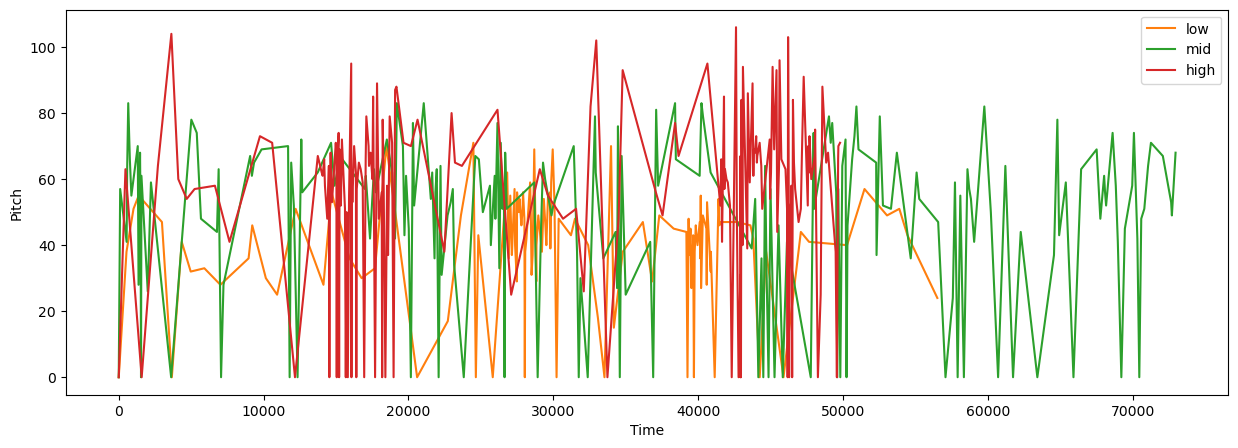

In [25]:
def plotter(midi):
    pitch_set = []
    time_set = []
    fig, ax = plt.subplots(figsize=(15, 5))
    for track in midi.tracks:
        pitches = [note.note for note in track if note.type=='note_on']
        time = [note.time for note in track if note.type=='note_off']
        times = np.cumsum(time)
        y = np.insert(pitches, 0, 0)
        x = np.insert(times, 0, 0)
        ax.plot(x, y, label=track.name)
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Pitch')
    plt.show()
plotter(mid)